# 43008: Reinforcement Learning

## Week 8: Temporal-Difference Methods: Control
## Part B: Double Q-Learning

This notebook will explore the implementation of a Temporal-Difference (TD) method, Double Q-Learning, on the CliffWalking and Taxi environment.

* Double Q-Learning Algorithm for Gym based environments

### What you will learn?
* Implement Double Q-Learning Algorithm
* Use Double Q-Learning on Cliffwalking and Taxi Environments

## 1. Imports and Utilities




In [ ]:
!pip install gymnasium pyvirtualdisplay
!apt-get install -y xvfb ffmpeg

In [ ]:
import sys
import gymnasium as gym
import numpy as np
import random
import glob
import io
import base64
from collections import namedtuple
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from gymnasium.wrappers import RecordVideo

from IPython.display import HTML
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

### Utility Functions




#### Plot Values

In [ ]:
# Function to plot the Episode statistics
# Adapted from: https://github.com/dennybritz/reinforcement-learning/blob/master/lib/plotting.py

def plot_episode_stats(stats, smoothing_window=10, noshow=False):

    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    if noshow:
        plt.close(fig3)
    else:
        plt.show(fig3)

    return fig1, fig2, fig3

In [ ]:
# Plot State Values
def plot_values(V, shape, pvals='v'):
    # Reshape the value function V to the given shape
    V = np.reshape(V, shape)

    # Create a new figure with a specific size
    fig = plt.figure(figsize=(15,5))

    # Add a subplot to the figure. 111 means 1x1 grid, first subplot.
    ax = fig.add_subplot(111)

    # Display the reshaped value function V as an image on the axes
    im = ax.imshow(V, cmap='cool')

    # For each value in V, annotate the plot with the value's rounded label
    for (j,i),label in np.ndenumerate(V):
        ax.text(i, j, np.round(label,3), ha='center', va='center', fontsize=14)

    # Disable ticks and tick labels for both x and y axes
    plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')

    # Set the title for the plot
    if pvals =='v':
       plt.title('State-Value Function')
    else:
       plt.title('Policy Plot (Action Value)')

    # Display the plot
    plt.show()


#### Simulate and show video

In [ ]:
def simulate_and_show_video(env, p):
    """
    Simulate an environment using a given policy and display the video.

    Parameters:
    - env: The environment to simulate.
    - p: The policy to use for taking actions.

    Returns:
    - HTML object if video was captured, or a message indicating no videos were found.
    """

    # Create a video recorder for the environment, saving the video as 'video.mp4'
    # Use RecordVideo wrapper instead of VideoRecorder
    env = RecordVideo(env, video_folder='./', name_prefix='video')

    # Reset the environment to its initial state
    state, info = env.reset()
    done = False

    # Keep simulating the environment until it's done
    while not done:
        # Select an action based on the current state and the given policy
        action = p[state]

        # Take a step in the environment using the selected action
        # The step method returns:
        # - state: The new state of the environment after taking the action
        # - reward: The reward obtained by taking the action
        # - terminated: A boolean indicating if the environment has reached a terminal state
        # - truncated: A boolean indicating if the episode was truncated
        # - info: A dictionary with auxiliary diagnostic or debugging information
        next_state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Update state
        state = next_state

    # Close the environment (which also finalizes the video recording)
    env.close()

    # Look for the '.mp4' files in the current directory
    mp4list = glob.glob('*.mp4')

    # If there are any .mp4 files
    if len(mp4list) > 0:
        # Select the first .mp4 file
        mp4 = mp4list[0]

        # Read the video file
        video = io.open(mp4, 'r+b').read()

        # Encode the video in base64 format
        encoded = base64.b64encode(video)

        # Return an HTML video tag to display the video
        return HTML(data='''<video alt="test" autoplay
                       loop controls style="height: 400px;">
                       <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                    </video>'''.format(encoded.decode('ascii')))
    else:
        # If no .mp4 files were found, return a message
        return "No videos found"

## 2. TD Control Algorithms



### 2.1 Helper function:

#### Epsilon Greedy Action Selection

In [ ]:
def epsilon_greedy_policy(Q, state, epsilon):
    """
    Select an action using epsilon-greedy policy.

    Parameters:
    - Q 2D np array: A 2S array that maps state to action values.
                For example, Q[state] = [0.1, 0.2, 0.4] for a 3-action environment.
    - state (int): Current state of the agent in the environment.

    - epsilon (float): The probability of choosing a random action (exploration factor).
                   It should be between 0 (no exploration) and 1 (only exploration).

    Returns:
    - action (int): The chosen action based on the epsilon-greedy policy.
    """
    # Generate a random number between 0 and 1. If it's less than epsilon,
    # then choose a random action, else the greedy action (the action with the maximum Q-value for the current state)
    if random.uniform(0,1) < epsilon:
        return env.action_space.sample()
    else:
        return max(list(range(env.action_space.n)), key = lambda x: Q[(state,x)])

#### Policy Extraction from Optimal-Q Values

In [ ]:
def extract_policy_V_from_Q_flat(Q, env):
    """
    Extract flat policy and state-value function V from Q.

    Params:
    - Q: Action-value function.
    - env: The environment to extract policy and V for.

    Returns:
    - policy: Derived flat policy from Q.
    - V: Derived flat state-value function from Q.
    """

    n_states = env.observation_space.n
    policy = np.empty(n_states, dtype=np.int64)
    V = np.empty(n_states, dtype=np.float64)

    for state in range(n_states):
            policy[state] = np.argmax(Q[state, :])
            V[state] = np.max(Q[state, :])

    return policy, V

### 2.2 Double Q-Learning



#### Pseudo-code for Double Q-Learning (off-policy TD control) from Sutton and Barto's book:




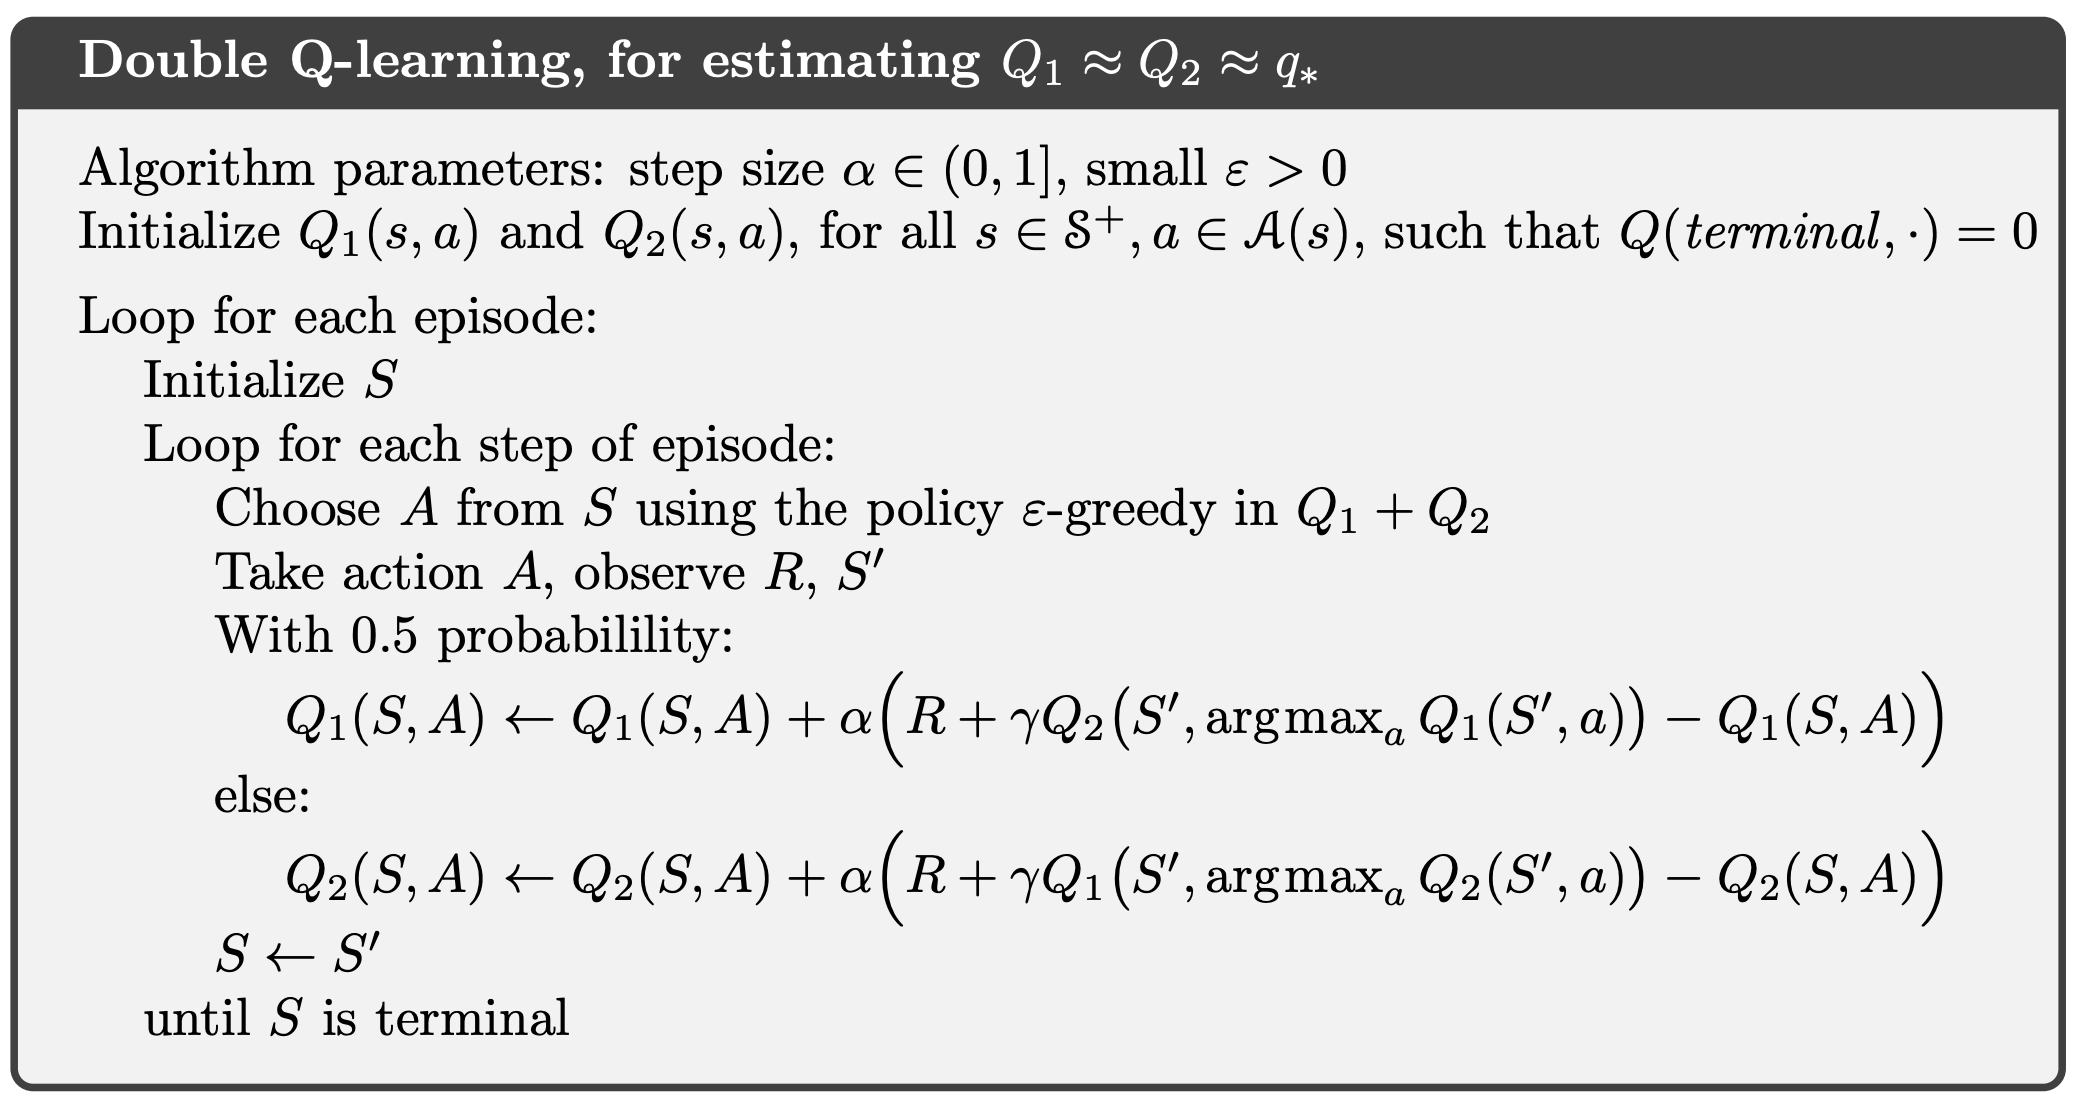

## Double Q-Learning Algorithm Code

In [ ]:
def update_epsilon(episode, initial_epsilon=1.0, min_epsilon=0.05, decay_factor=0.99):
    """
    Compute the decaying epsilon for the epsilon-greedy policy.

    Parameters:
    - episode (int): Current episode number.
    - initial_epsilon (float): Initial epsilon value at the start.
    - min_epsilon (float): Minimum epsilon value to which decay will occur.
    - decay_factor (float): Rate at which epsilon will decay.

    Returns:
    - epsilon (float): Decayed epsilon value.
    """

    decayed_epsilon = (initial_epsilon - min_epsilon) * np.exp(-decay_factor * episode)
    epsilon = min_epsilon + decayed_epsilon

    return epsilon

In [ ]:
# Double Q-Learning Algorithm
def double_q_learning(env, num_episodes, gamma=1.0, alpha=0.85):
    """
    Double Q-Learning algorithm: An off-policy TD control method that reduces
    overestimation bias of Q-Learning by maintaining two Q tables.

    Parameters:
    - env: The environment to be used.
    - num_episodes (int): Number of episodes to run the algorithm.
    - alpha (float): The step-size parameter (learning rate).
    - gamma (float): The discount factor. Default value is 1.0.
    - plot_every (int): Number of episodes to use when plotting performance.

    Returns:
    - Q (dict): Optimal action-value function.
    """

    # Initialize two action-value functions with zeros
    Q1 = ## WRITE YOUR CODE HERE ##
    Q2 = ## WRITE YOUR CODE HERE ##
    Q  = ## WRITE YOUR CODE HERE ##

    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # Keep track of average rewards
    avg_rewards = []

    for episode in range(num_episodes):

        # Update epsilon for the current episode
        epsilon = ## WRITE YOUR CODE HERE ##

        # Observe initial state
        state = ## WRITE YOUR CODE HERE ##

        # Initialize the score for this episode
        r = ## WRITE YOUR CODE HERE ##

        # Reset the Episodes time step, will be used for stats
        timeStep= ## WRITE YOUR CODE HERE ##

        while True:
            # Select action using epsilon-greedy policy derived from Q1 + Q2
            action = ## WRITE YOUR CODE HERE ##

            # perform the action and move to the next state, and receive the reward
            next_state, reward, terminated, truncated, info = ## WRITE YOUR CODE HERE ##
            done = terminated or truncated

            # Update statistics
            stats.episode_rewards[episode] += reward
            timeStep +=1
            stats.episode_lengths[episode] = timeStep

            # Randomly choose which Q-table to update
            if np.random.rand() < 0.5:
                # Update Q1 using max action from Q2
                best_next_action = ## WRITE YOUR CODE HERE ##
                TD_target = ## WRITE YOUR CODE HERE ##
                TD_error = ## WRITE YOUR CODE HERE ##
                Q1[state, action] += ## WRITE YOUR CODE HERE ##
            else:
                # Update Q2 using max action from Q1
                best_next_action = ## WRITE YOUR CODE HERE ##
                TD_target = ## WRITE YOUR CODE HERE ##
                TD_error = ## WRITE YOUR CODE HERE ##
                Q2[state, action] += ## WRITE YOUR CODE HERE ##

          # Update the state and BUT NOT action with next action and next state
            state = ## WRITE YOUR CODE HERE ##

          # store the rewards
            avg_rewards.append(## WRITE YOUR CODE HERE ##)

          # Break the loop, if it is the terminal state of the episode
            if done:
               break

    # Combine Q1 and Q2 to get final Q-values
    Q = ## WRITE YOUR CODE HERE ##

    print("Max Rewards : ", np.max(avg_rewards))
    return Q, stats

## 3. Running the Double Q-Learning Algorithms on different environments and Plotting Results



## CliffWalking Environment Exploration

The CliffWalking environment is a standard undiscounted, episodic task, with start and goal states, and the usual actions causing movement up, down, right, and left. The reward is -1 on all transitions except those into the region marked "The Cliff". Stepping into this region incurs a reward of -100 and sends the agent instantly back to the start.



In [ ]:
# Create an instance of the 'CliffWalking-v0' environment.
# 'CliffWalking' is a standard gridworld environment where the agent has to navigate from a start state to a goal state,
# avoiding falling off a cliff.
env = ## WRITE YOUR CODE HERE ##

# Print the action space of the environment.
# This will show the number of possible actions an agent can take in the environment.
print(env.action_space)

# Print the observation space of the environment.
# This will show the number of possible states (or observations) an agent can encounter in the environment.
print(env.observation_space)

### Train the agent using Double Q-Learning

In [ ]:
# Train agent using the Q-Learning algorithm
DoubleQ_table, stats = ## WRITE YOUR CODE HERE ##

### Extract policy and plot the value function

In [ ]:
# The Episode Statistics
plot_episode_stats(stats)

In [ ]:
# Extract the optimal policy and corresponding state-value function (V)
# from the action-value function (Q_table) using the 'extract_policy_V_from_Q_flat' function.
# 'Q_table' is the action-value function derived from the Double Q-Learning algorithm.
policy_DQL, V_DQL = extract_policy_V_from_Q_flat(DoubleQ_table, env)

# Visualize the state-value function (V_table) using the 'plot_values' function.
# The state-value function is reshaped into a grid of size (4, 12) for visualization.
# In the context of the 'CliffWalking-v0' environment, the grid represents the layout of the environment
# with 4 rows and 12 columns.
plot_values(V_DQL, (4, 12))
plot_values(policy_DQL, (4, 12), pvals='a')


### Simulating the Optimal Policy

To visualize how the agent performs using the optimal policy derived from the Q-Learning algorithm, we'll simulate the environment and generate a video.

In [ ]:
# Simulate the environment using the optimal policy suggested by Q-Learning and display the video
simulate_and_show_video(env, policy_DQL)

## Taxi Environment Exploration




In [ ]:
# Create an instance of the 'Taxi-v3' environment.
# 'Taxi-v3' is a standard gridworld environment where the agent needs to pick up a passenger
# from a location and drop them off at another location, navigating through the grid.
env = ## WRITE YOUR CODE HERE ##

# Print the action space of the environment.
# This will display the number of possible actions an agent can take in the environment.
print(env.action_space)

# Print the observation space of the environment.
# This will display the number of possible states (or observations) an agent can encounter in the environment.
print(env.observation_space)


### Train the agent using Double Q-Learning

In [ ]:
# Train agent using the Q-Learning algorithm
DoubleQ_table, stats = ## WRITE YOUR CODE HERE ##

### Extract policy


In [ ]:
# Using the 'extract_policy_V_from_Q_flat' function, extract the optimal policy (policy_QL)
# and the corresponding state-value function (V_QL) from the action-value function (Q_table)
# for the given environment (env).
# 'Q_table' is the action-value function derived from the Q-Learning algorithm.
policy_DQL, V_DQL = extract_policy_V_from_Q_flat(DoubleQ_table, env)

#### Note: We cannot plot the value function as taxi has 500 states, which do not relate to the grid. Each grid box can have approximately 20 different states as it is a 5x5 grid world.

### Simulating the Optimal Policy

To visualize how the agent performs using the optimal policy derived from the Double Q-Learning algorithm, we'll simulate the environment and generate a video.

In [ ]:
# Simulate the environment using the optimal policy derived from Q-Learning and display the video
simulate_and_show_video(env, policy_DQL)